In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pymongo import MongoClient
import os

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['breast_cancer_wisconsin']
collection = db['cleaned_data']

# Retrieve data from MongoDB
df = pd.DataFrame(list(collection.find()))

# Map 'diagnosis' to 'Benign' and 'Malignant'
df['diagnosis'] = df['diagnosis'].map({'B': 'Benign', 'M': 'Malignant'})

In [2]:
# Creating Files for Images
output_folder_boxplots = './img/boxplots'
os.makedirs(output_folder_boxplots, exist_ok=True)

output_folder_pairplots = './img/pairplots'
os.makedirs(output_folder_pairplots, exist_ok=True)

output_folder_densityplots = './img/densityplots'
os.makedirs(output_folder_densityplots, exist_ok=True)

output_folder_distributionplots = './img/correlationplots'
os.makedirs(output_folder_distributionplots, exist_ok=True)

output_folder_probabilityplots = './img/probabilityplots'
os.makedirs(output_folder_probabilityplots, exist_ok=True)

output_folder_correlationplots = './img/correlationplots'
os.makedirs(output_folder_correlationplots, exist_ok=True)

In [3]:
#Defining color mapping for 'Benign' and 'Malignant' (because we like pretty things :) ) 
color_map = {'Benign': 'darkturquoise', 'Malignant': 'darkred'}

#Defining the four main metric groups for cleaner visualisation
size_metrics = ['radius_mean', 'area_mean', 'perimeter_mean']
shape_metrics = ['concavity_mean', 'concave points_mean', 'smoothness_mean']
texture_metrics = ['texture_mean', 'texture_worst']
compactness_metrics = ['compactness_mean', 'compactness_worst']

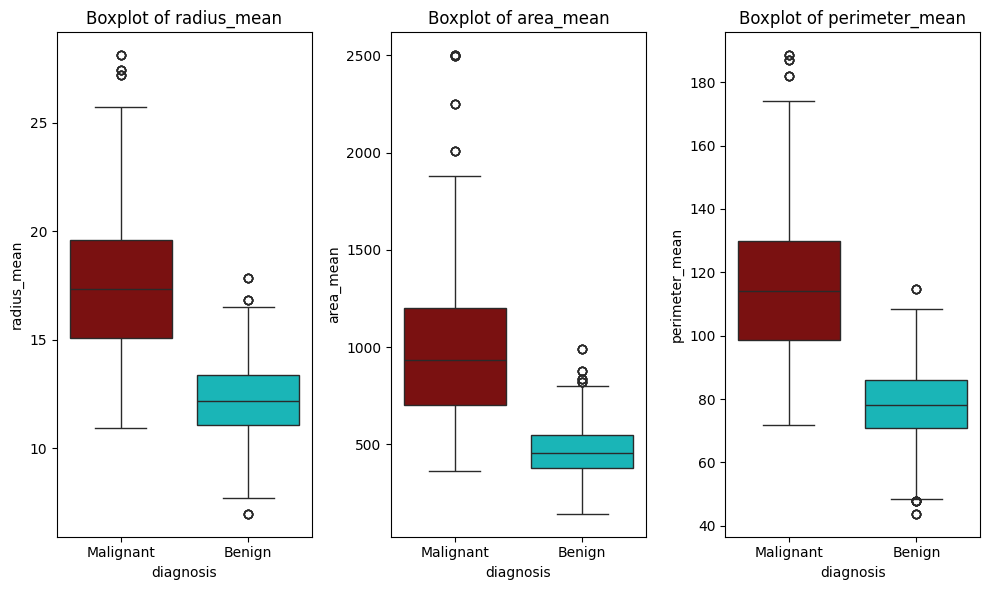

In [4]:
#Size: Boxplots
plt.figure(figsize=(10, 6))
for i, metric in enumerate(size_metrics, 1):
    plt.subplot(1, len(size_metrics), i)
    sns.boxplot(x='diagnosis', y=metric, data=df, 
                hue='diagnosis', 
                dodge=False,  
                palette=color_map)
    plt.title(f"Boxplot of {metric}")
    plt.xlabel("diagnosis")
    plt.ylabel(metric)
plt.tight_layout()

plot_path = os.path.join(output_folder_boxplots, 'Boxplot_size_metrics.png')
plt.savefig(plot_path)

plt.show()

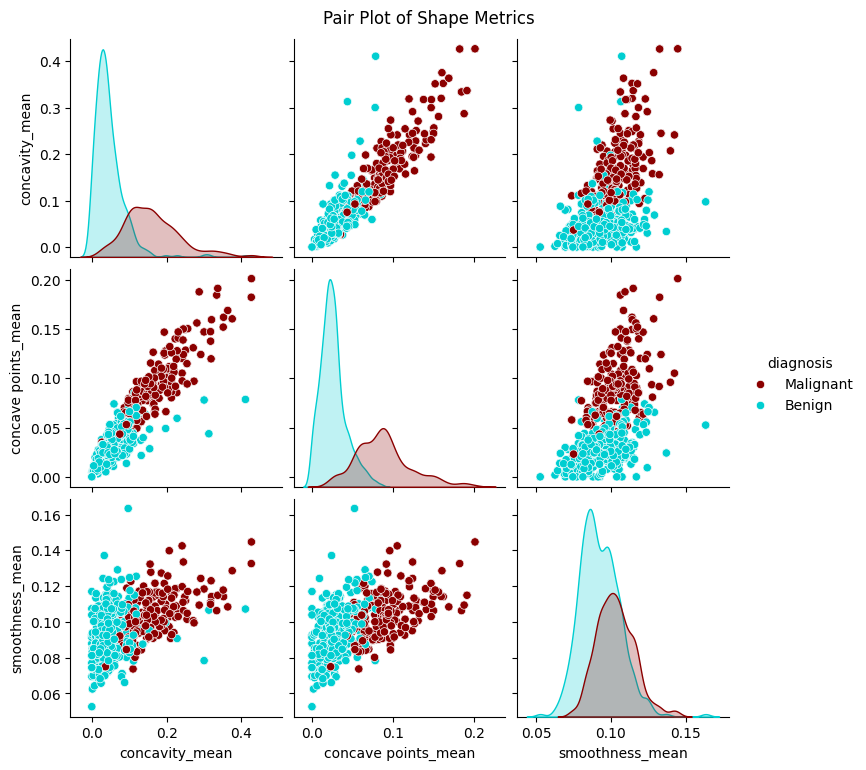

In [5]:
#Shape: Pair Plots 
sns.pairplot(
    df[shape_metrics + ['diagnosis']],
    hue='diagnosis', 
    diag_kind='kde', 
    palette=color_map  
)
plt.suptitle("Pair Plot of Shape Metrics", y=1.02)

plot_path = os.path.join(output_folder_pairplots, 'Pairplots_shape_metrics.png')
plt.savefig(plot_path)

plt.show()

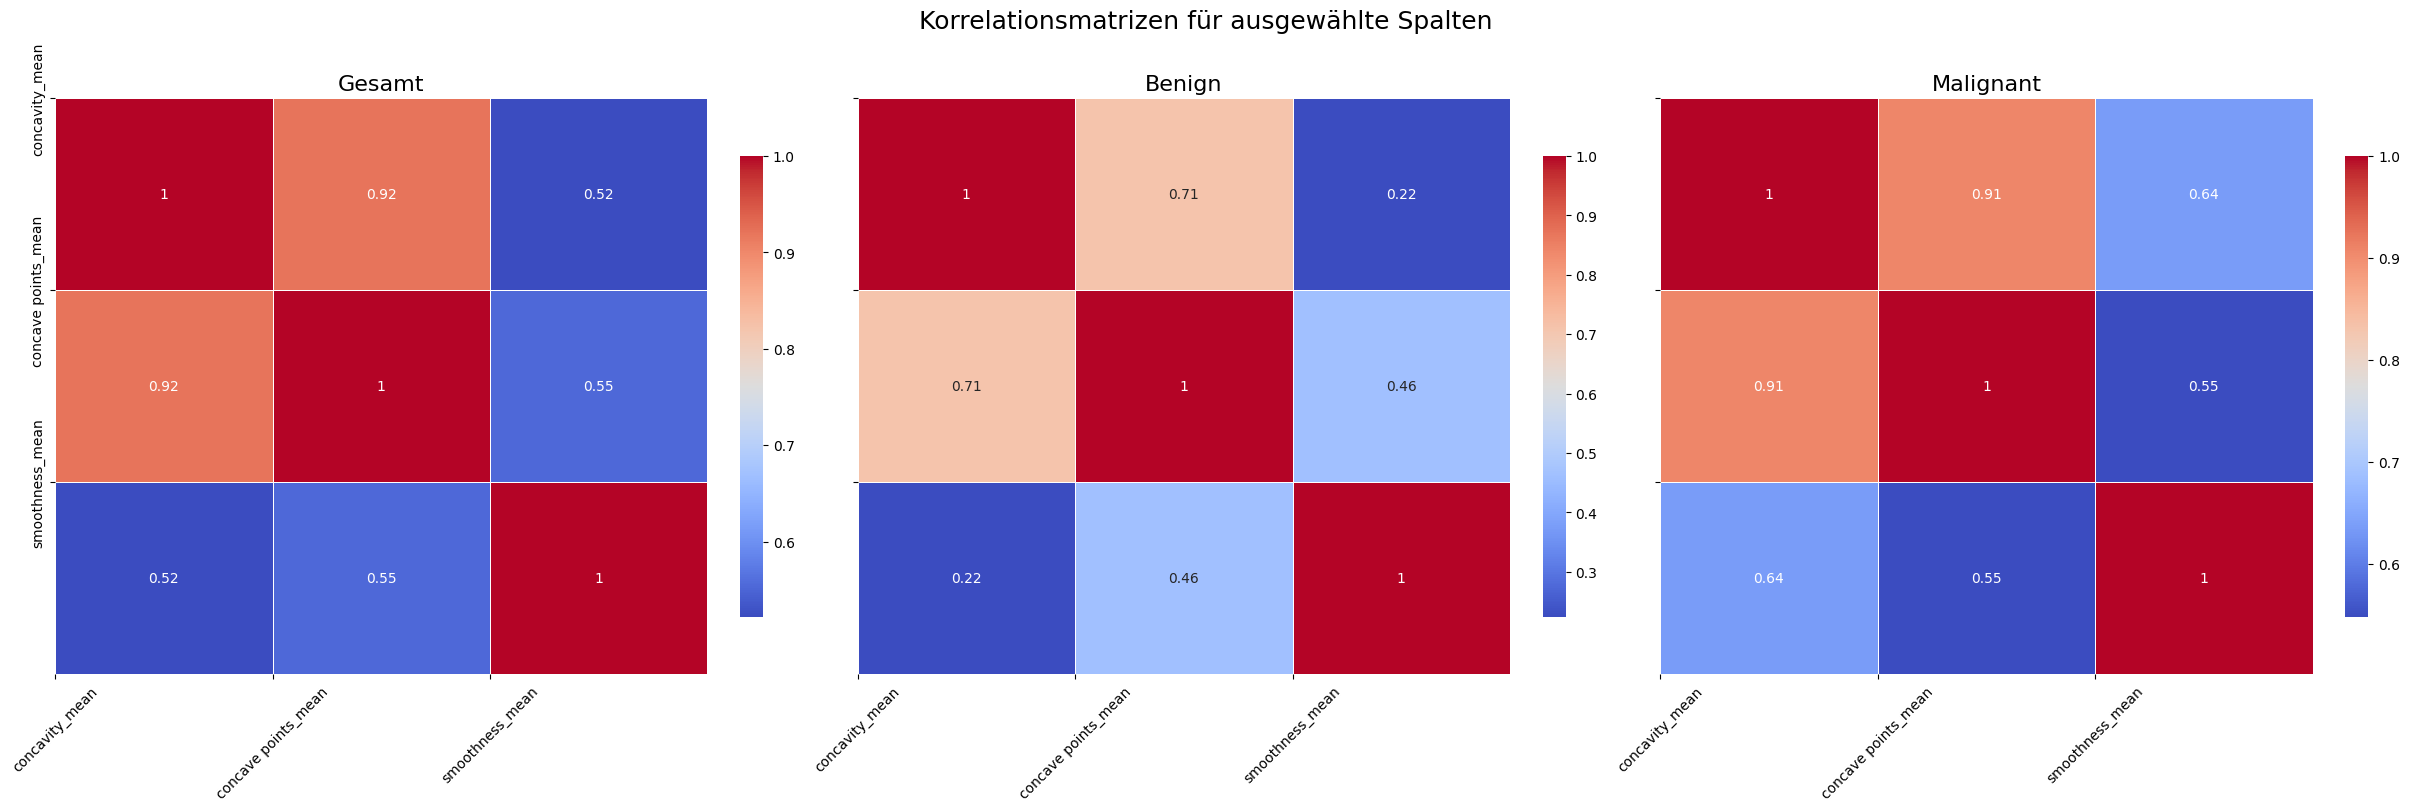

In [6]:
# Creating Correlation-Plots
def get_correlation_matrix(data, columns):
    numerische_spalten = data[columns]
    return numerische_spalten.corr(method='pearson')

def plot_heatmap(ax, correlation_matrix, title, shape_metrics, show_y_labels=True):
    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        cmap='coolwarm', 
        ax=ax, 
        cbar_kws={"shrink": 0.8},
        annot_kws={"size": 10}, 
        linewidths=0.5
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticks(range(len(shape_metrics)))
    ax.set_yticks(range(len(shape_metrics)))
    ax.set_xticklabels(shape_metrics, fontsize=10, rotation=45)
    if show_y_labels:
        ax.set_yticklabels(shape_metrics, fontsize=10)
    else:
        ax.set_yticklabels([])

correlation_full = get_correlation_matrix(df, shape_metrics)
correlation_benign = get_correlation_matrix(df[df['diagnosis'] == 'Benign'], shape_metrics)
correlation_malignant = get_correlation_matrix(df[df['diagnosis'] == 'Malignant'], shape_metrics)

fig, axes = plt.subplots(1, 3, figsize=(24, 8), constrained_layout=True)

plot_heatmap(axes[0], correlation_full, 'Gesamt', shape_metrics, show_y_labels=True)
plot_heatmap(axes[1], correlation_benign, 'Benign', shape_metrics, show_y_labels=False)
plot_heatmap(axes[2], correlation_malignant, 'Malignant', shape_metrics, show_y_labels=False)

plt.suptitle('Korrelationsmatrizen für ausgewählte Spalten', fontsize=18)

plot_path = os.path.join(output_folder_correlationplots, 'korrelationsplots_shape_metrics.png')
plt.savefig(plot_path)

plt.show()

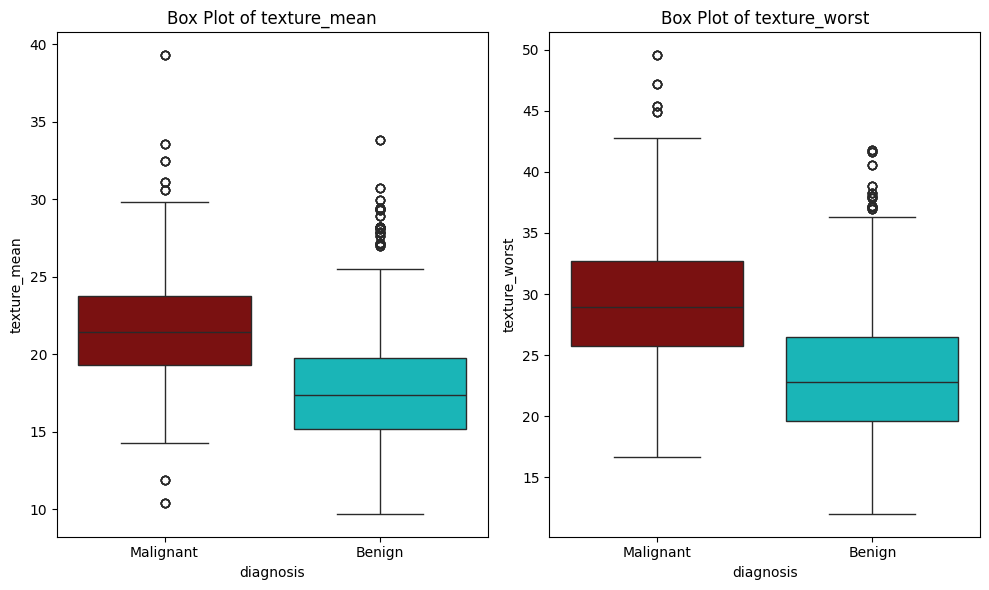

In [7]:
#Texture: Box Plots 
plt.figure(figsize=(10, 6))
for i, metric in enumerate(texture_metrics, 1):
    plt.subplot(1, len(texture_metrics), i)
    sns.boxplot(x='diagnosis', y=metric, data=df, 
                hue='diagnosis', 
                dodge=False,  
                palette=color_map)
    plt.title(f"Box Plot of {metric}")
    plt.xlabel("diagnosis")
    plt.ylabel(metric)
plt.tight_layout()

plot_path = os.path.join(output_folder_boxplots, 'Boxplot_texture_metrics.png')
plt.savefig(plot_path)

plt.show()

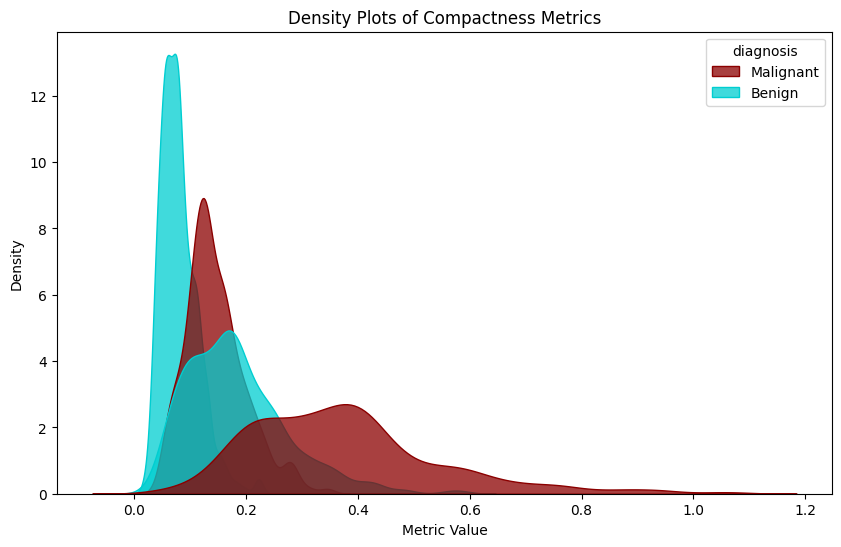

In [8]:
#Compactness: Density Plot 
plt.figure(figsize=(10, 6))
for metric in compactness_metrics:
    sns.kdeplot(
        data=df,
        x=metric,
        hue='diagnosis', 
        fill=True, 
        common_norm=False, 
        alpha=0.75, 
        palette=color_map  
    )
plt.title("Density Plots of Compactness Metrics")
plt.xlabel("Metric Value")
plt.ylabel("Density")

plot_path = os.path.join(output_folder_densityplots, 'Densityplot_compactness_metrics.png')
plt.savefig(plot_path)

plt.show()

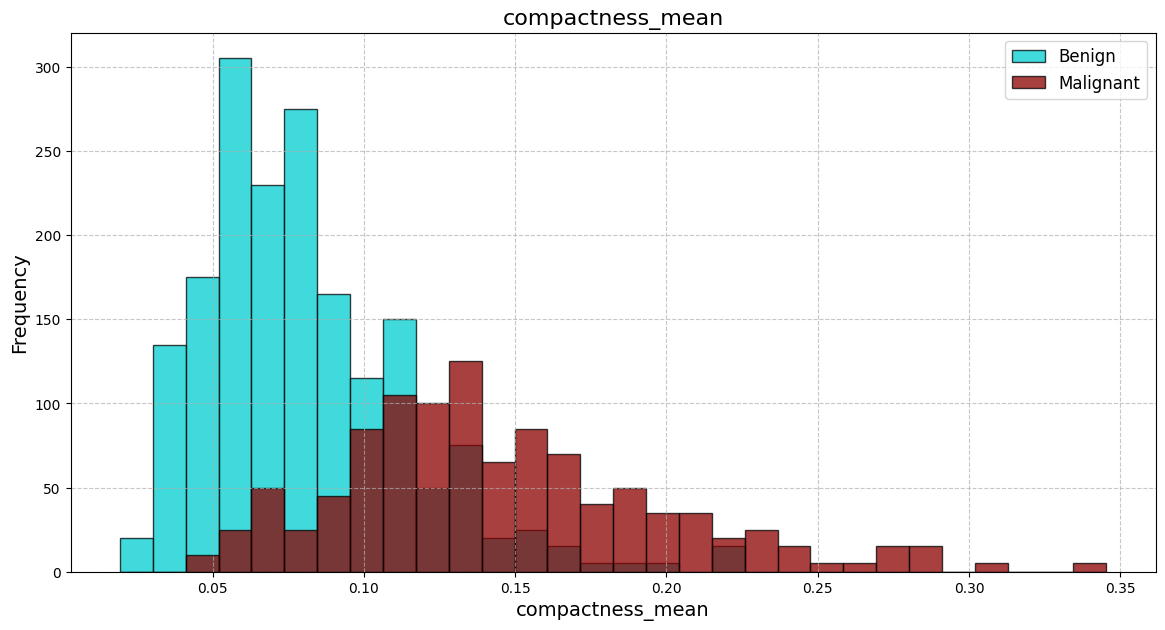

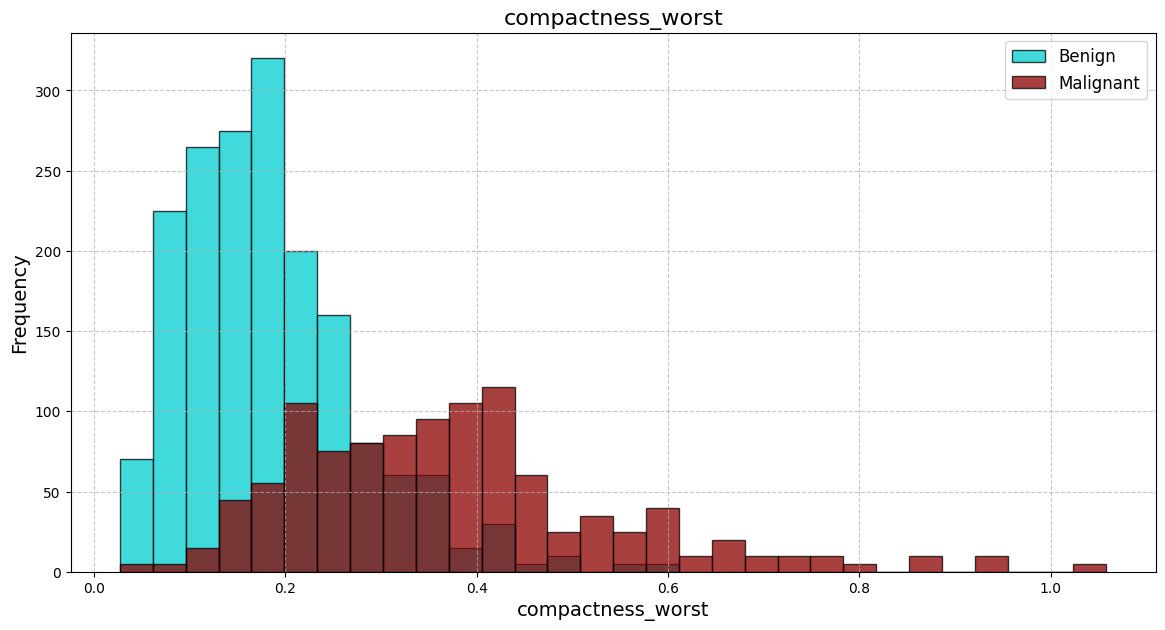

In [9]:
# Create bar charts for each metric
for metric in compactness_metrics:
        benign_values = df[df['diagnosis'] == 'Benign'][metric]
        malignant_values = df[df['diagnosis'] == 'Malignant'][metric]
        
        bins = 30
        bin_edges = np.linspace(min(df[metric]), max(df[metric]), bins + 1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        
        benign_counts, _ = np.histogram(benign_values, bins=bin_edges)
        malignant_counts, _ = np.histogram(malignant_values, bins=bin_edges)

        plt.figure(figsize=(14, 7))
        plt.bar(bin_centers, benign_counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.75, label='Benign', color=color_map['Benign'], edgecolor='black')
        plt.bar(bin_centers, malignant_counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.75, label='Malignant', color=color_map['Malignant'], edgecolor='black')
        
        plt.title(f"{metric}", fontsize=16)
        plt.xlabel(metric, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

In [10]:
# Calculation and visualization of distributions
for column in df.select_dtypes(include=[float, int]).columns:  # Select numeric columns
    plt.figure(figsize=(14, 7))
        
    benign_data = df[df['diagnosis'] == 'Benign'][column]
    malignant_data = df[df['diagnosis'] == 'Malignant'][column]
        
    sns.kdeplot(benign_data, label='Benign', color=color_map['Benign'], fill=True, alpha=0.75)
    sns.kdeplot(malignant_data, label='Malignant', color=color_map['Malignant'], fill=True, alpha=0.75)
        
    plt.title(f'Probability distribution for {column}', fontsize=16)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Density', fontsize=14)  # Changed 'Dichte' to 'Density'
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    plot_path = os.path.join(output_folder_probabilityplots, f'probability_{column}.png')  # Updated filename to English
    plt.savefig(plot_path)
    plt.close()

    plt.show()